<div style="direction:rtl;line-height:300%; font-family: Yas">
    <font face="XB Zar" size=5>
        <div style="direction:rtl;line-height:300%; font-family: Yas">
            <font   size=5>
                <div align=center>
                    <font  size=۲۰>
                        <p></p>
                        مبین نیک خصال
                    </font>
                    <br>
                    <br>
                    اردیبهشت ۱۳۹۹
                </div>
            </font>
        </div>
    </font>
</div>

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
        در این فایل به بررسی 
        data_train.csv
        می پردازیم 
        و مدل های ساخته شده را در پوشه 
        model
        قرار می دهیم.
        پیش بینی بر اساس این مدل توسط فایل
        predication.py
         انجام خواهد شد
        که در پوشه code
        موجود است.
        ونتایج آن در پوشه
        data 
        در دسترس است.
    </font>
</div>

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
        ابتدا کتابخانه مورد نیاز برای تحلیل اکتشافی دادگان را وارد می کنیم
        .
    </font>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
        و کتابخانه مورد نیاز برای مدل سازی را وارد می کنیم.
    </font>
</div>

In [2]:
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report ,confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle

from xgboost import XGBClassifier

from joblib import dump

In [3]:
df_raw= pd.read_csv("../data/data_train.csv",na_values="?",header=None)

In [4]:
df_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
0,1.000000,0.750000,0.857143,0.857143,0.806452,0.800000,s,n,1.0,1.0,...,0.461538,0.294118,n,0.999652,0.500000,0.352941,n,0.999936,1.000000,1
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,s,s,NaN,NaN,...,1.000000,1.000000,s,1.000000,1.000000,1.000000,s,1.000000,1.000000,1
2,1.000000,0.666667,0.800000,0.800000,0.619048,0.777778,s,n,NaN,NaN,...,0.333333,0.125000,n,0.984446,0.666667,0.333333,n,1.000000,0.999543,1
3,0.666667,0.666667,0.714286,0.666667,0.363636,0.517241,n,n,NaN,NaN,...,0.625000,0.500000,n,0.999544,0.666667,0.545455,n,1.000000,1.000000,1
4,0.666667,0.500000,0.761905,0.612245,0.631579,0.478261,n,n,NaN,NaN,...,0.777778,0.454545,n,0.999988,0.777778,0.538462,n,1.000000,1.000000,1


<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
         می دانیم با یک مسئله دسته بندی روبه‌رو هستیم.
        لاجرم بعد وارد کردن دادگان در ابتدا میزان بالانس بودن برچسب ها نگاه می‌کنیم
    </font>
</div>

In [5]:
df_raw[118].value_counts(normalize=True)

 1    0.713876
-1    0.286124
Name: 118, dtype: float64

In [6]:
# seperate the features columns and target column
data = df_raw.iloc[:,0:118].copy()
target = df_raw.iloc[:,118].copy()

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
به دلیل یکنواختی جریان بررسی، توابع، در اینجا
        نیز قرار داده شداند، اما در فایل 
        utils.py
        در پوشه کد نیز در دسترس است
        . از توضیح اضافه خوداری می‌کنم و 
در حد توانم در 
docstring
در مورد توابع توضیحاتی داده ام
    </font>
</div>

In [7]:
def cat_num_split(df):
    """
    Description:
    ------------
    take a pandas data frame and base "object" data type
    in pandas split categorical and numerical columns.
    
    Parameters
    ----------
    df : pandas data frame
    
    Returns
    -------
    cat_df : contians all categorcal columns
    num_df : contians all numerical columns
    """
    categorical = []
    numerical = []
    for col in df.columns:
        if df[col].dtype == 'O': # "O" stands for Object
            categorical.append(col)
        else:
            numerical.append(col)
    if len(categorical) + len(numerical) != df.shape[1]: # checking the all columns examine
        raise("#cat and #num is not equal #total columns")
    cat_df = df[categorical].copy()
    num_df = df[numerical].copy()    
    return cat_df, num_df


def null_ratio(df,atmost_null=0.6):
    """
    Description:
    ------------
    Take a data frame and filter the some columns that have 
    null percent cell more than specific value value(atmost_null)

    Parameters
    ----------
    df : pandas data frame
    
    atmost_null : the maximun ratio that a column can be contained  null values. 
    if a column has more null then filtered.
    
    Returns
    -------
    not_null_columns (python list): columns which have not any null cells.
    at_most_columns (python list): columns which have null but not more than "atmost_null" criterion.
    -------
    """
    at_most_columns = []
    not_null_columns = []
    temp = df.isna().sum()/len(df) # pandas series that shows null ratio of ecah column
    for index, value in temp.items():
        if 0 < value < atmost_null:
                at_most_columns.append(index)
        elif value == float(0):
            not_null_columns.append(index)    
    return not_null_columns, at_most_columns


def univariant_importance(est,df,target,atmost_null=0.5):
    """
    Description:
    ------------
    Take a scikit learn predictor(estimator) and, bulid simple model
    base on actual value of **single** column and taget to find out 
    the importance of these columns, fianaly we have a report.
    **It works just for numberical columns.
    
    Parameters
    ----------
    est: scikit learn predictor. It must choose from a class in scikit learn
    that contian "fit" and "predict" mehtods.
    
    df:pandas data frame. Be curefull you must remove the target column from df.
    
    target: columns of labels.
    
    atmost_null : the maximun ratio that a column can be contained  null values. 
    if a column has more null then filtered.

    Returns
    -------
    out: a pandas data frame that has four columns:
        "col": the name of the column.
        "#": the number of non-null values in which this column has it.
        "accuracy": the accuracy which the predictor find base of "cross_val_score" with 10 folds(cv=10).
        "[#-1 , #+1]": the numbers class member.
        "majority": the ratio of majority class to total non-null values.
    """
    _, cols = null_ratio(df,atmost_null)
    report=[]
    for col in cols:
        mask = df[col].isna().values
        X = df[col][~mask].values
        y = target[~mask].values
        nuiq = np.unique(y,return_counts=True)
        postive_ratio = nuiq[1][1]/(nuiq[1][1]+nuiq[1][0])
        negative_ratio = 1-postive_ratio
        majority = postive_ratio if  postive_ratio > negative_ratio else  negative_ratio
        score = np.mean(cross_val_score(est,X.reshape(-1,1),y,cv=10))
        report.append((col,len(X),score,nuiq[1],majority))
    out = pd.DataFrame(report,columns=["col","#","accuracy", "[#-1 , #+1]","majority"])
    return out


def select_columns(report,thershold=0.05):
    """
    Description:
    ------------
    It takes the report data frame from *univaiant_importance* function and
    selects the important columns from which have null values. I say a feature(column)
    is important if it can predict accuracy more the "threshold" from a random 
    predictor(I find it from "majority" column in report data frame).

    Parameters
    ----------
    report: report data frame from *univaiant_importance* function.
    thershold: the criterion for selecting informative columns
    
    Returns
    -------
    selected_cloumns: columns that select from the columns that 
    at least has one null values and has useful information
    """
    
    selected_cloumns= []
    for _, row in report.iterrows():
        if row[2]-row[4]>thershold:
            selected_cloumns.append(row[0])
    return selected_cloumns

def sample_imputer(df, selected_cloumns):
    """
    Description:
    ------------
    Take sample from non-null value and fill the null cell
    with these sample. (I find out it better and mean and madian)
    
    Parameters
    ----------
    df: pandas data frame
    selected_cloumns: the columns that achive from the *select_columns* function
    
    Returns
    -------
    df : The data frame that null cells of selected columns are filled
    """
    df = df.copy()
    for col in selected_cloumns:
        is_null = df[col].isna()
        null_num = is_null.sum()
        if null_num > 0:
            df.loc[is_null, col] = df[col][~is_null].sample(n=null_num, replace=True).values
    return df

def proba_to_pred(proba, threshold=0.5):
    """
    Description:
    ------------
    Take the probabilty of postive calss and return the hard classifiaction

    Parameters
    ----------
    proba: obabilty of postive calss.
    threshold : make decsion to assign to postive class
    
    Returns
    -------
    y_pred: the list contain +1 and -1
    """
    y_pred =np.zeros_like(proba[:,1])
    for i, prob in enumerate(proba[:,1]):
        if prob > threshold :
            y_pred[i] = +1
        else:
            y_pred[i] = -1
    return y_pred

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>  
        دو 
        data frame
        مجزا از ستون های حاوی ویژگی های 
        categorical
        و
        numberical 
        می سازیم.
    </font>
</div>

In [8]:
cat_df, num_df = cat_num_split(data)

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
        خوشبختانه
        دادگان
        categorical
        دارای 
        cell
        خالی نیستند.
    </font>
</div>

In [9]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31018 entries, 0 to 31017
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   6       31018 non-null  object
 1   7       31018 non-null  object
 2   14      31018 non-null  object
 3   15      31018 non-null  object
 4   22      31018 non-null  object
 5   23      31018 non-null  object
 6   30      31018 non-null  object
 7   31      31018 non-null  object
 8   38      31018 non-null  object
 9   39      31018 non-null  object
 10  46      31018 non-null  object
 11  47      31018 non-null  object
 12  54      31018 non-null  object
 13  55      31018 non-null  object
 14  62      31018 non-null  object
 15  63      31018 non-null  object
 16  70      31018 non-null  object
 17  71      31018 non-null  object
 18  78      31018 non-null  object
 19  79      31018 non-null  object
 20  86      31018 non-null  object
 21  87      31018 non-null  object
 22  91      31018 non-null

In [10]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31018 entries, 0 to 31017
Data columns (total 89 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       31018 non-null  float64
 1   1       31018 non-null  float64
 2   2       31018 non-null  float64
 3   3       31018 non-null  float64
 4   4       31018 non-null  float64
 5   5       31018 non-null  float64
 6   8       10940 non-null  float64
 7   9       10940 non-null  float64
 8   10      10940 non-null  float64
 9   11      10940 non-null  float64
 10  12      10940 non-null  float64
 11  13      10940 non-null  float64
 12  16      8449 non-null   float64
 13  17      8449 non-null   float64
 14  18      8449 non-null   float64
 15  19      8449 non-null   float64
 16  20      8449 non-null   float64
 17  21      8449 non-null   float64
 18  24      9037 non-null   float64
 19  25      9037 non-null   float64
 20  26      9037 non-null   float64
 21  27      9037 non-null   float64
 22

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
         برای نمایش داده های گسسته از 
        countplot
        استفاده می کنیم.
       مشاهده می کنیم که تا حدی خوبی
        همان نسبتی که در 
        label 
        ها موجود هست را بازنمایی می‌کنند.
    </font>
</div>

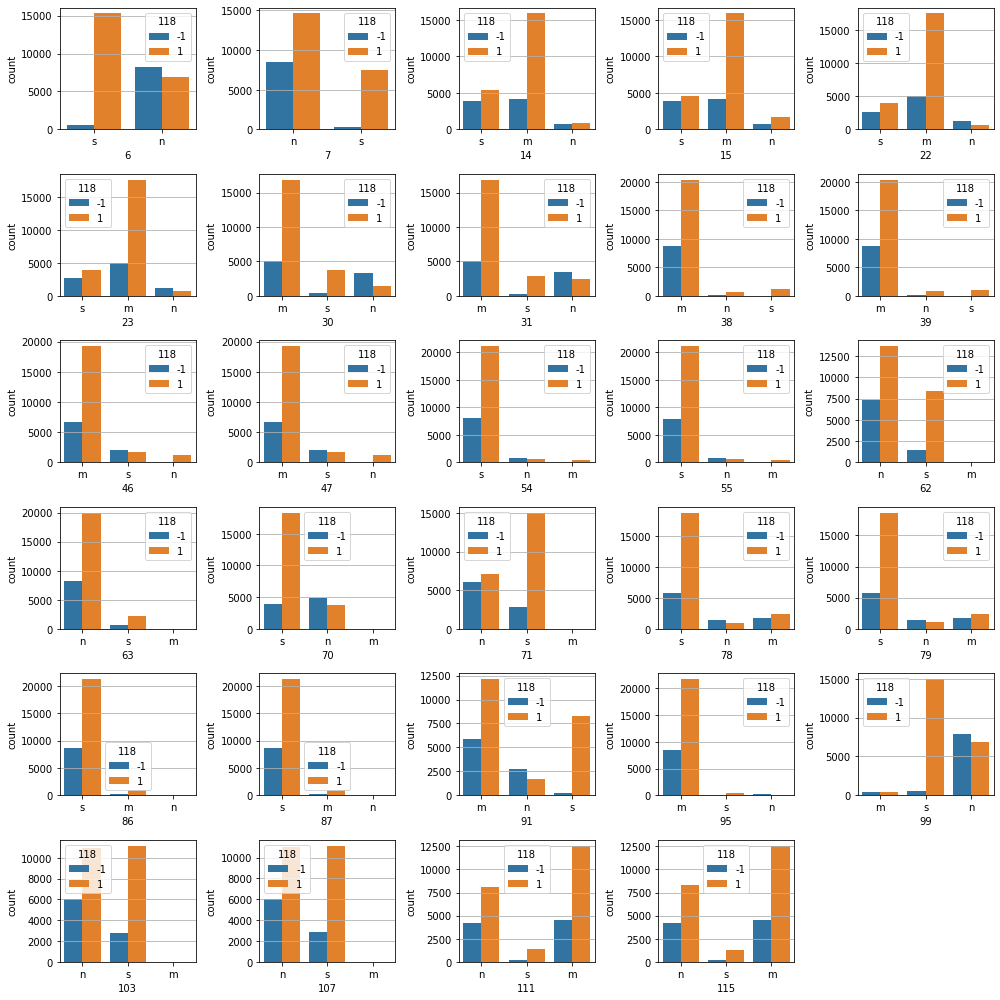

In [11]:
n_rows = 6
n_cols = 5
plt.figure(figsize=(14,14))
for i,col  in enumerate(cat_df.columns):
    i +=1
    plt.subplot(n_rows,n_cols,i)
    plt.grid(axis="y")
    sns.countplot(x=cat_df[col],hue=target)
    plt.tight_layout()

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
    برای دادگان عددی از 
    violinplot
    استفاده کردیم و توزیع هر ویژگی بر حسب دو کلاس موجود را رسم کردیم.
    (به علت بالا بودن تعداد ویژگی های عددی در دو بخش رسم شدند)
        .دو نکته ارزشمند در نمودار ها موجود است.
     <br>
    ۱) تمامی دادگان استاندارد شده اند و همه در حدود صفر تا یک هستند.
    <br>
    ۲)بسیاری از آن ها ارزش مقاسیه ای ندارند. برای مثال ویژگی ۴۹ را در نظر بگیرد برای هر دو کلاس
        مقادیر در حدود عدد یک متمرکز شده اند و تخمین گر ما مبتی بر این ویژگی توانای تمیز دادن این دو کلاس را ندارند. در 
        حقیقت
       باید بسیاری از آن ها فارق از وجود یا عدم وجود
        null_value
       کنار گذاشته شود چرا که مانند ویژگی ۴۹ هستند.
    </font>
</div>

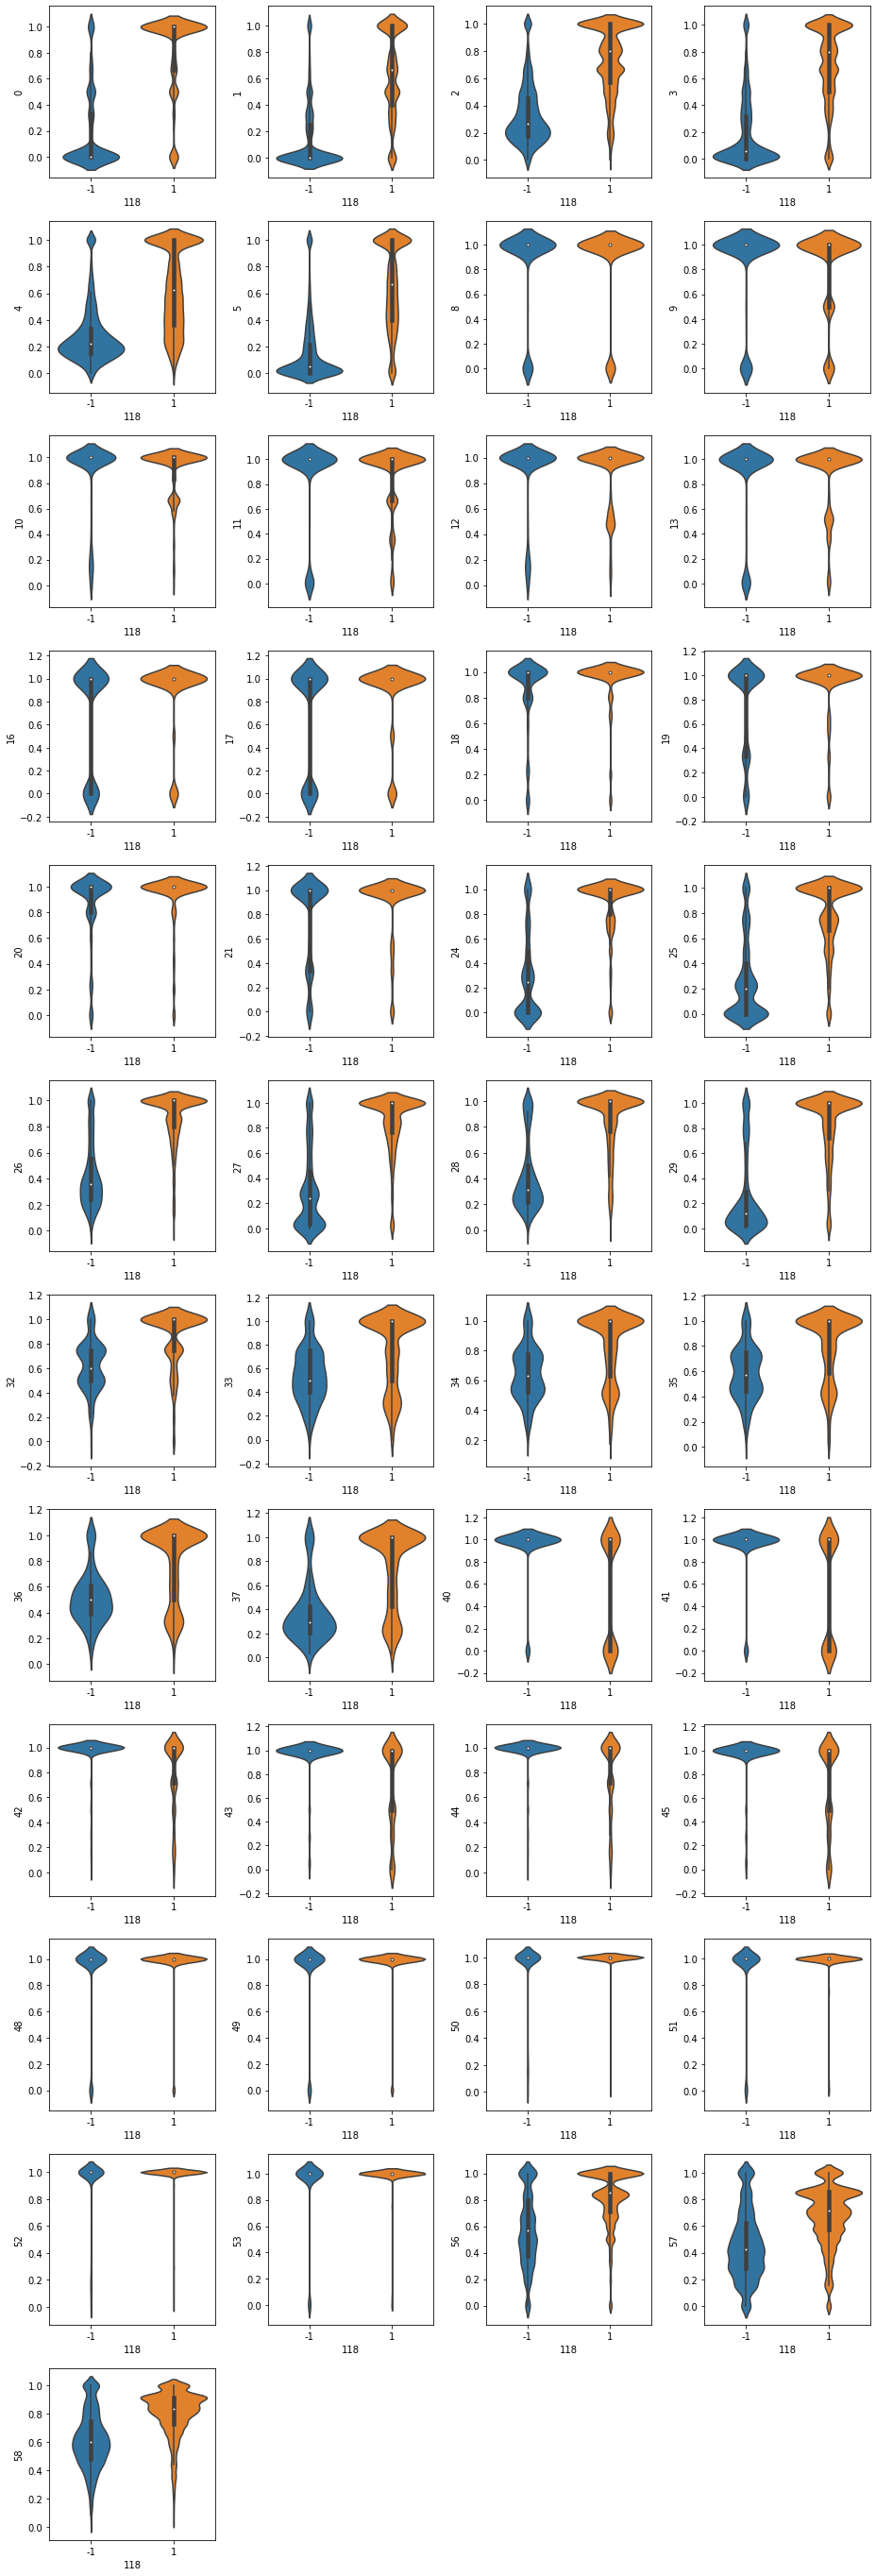

In [11]:
n_rows = 12
n_cols = 4
plt.figure(figsize=(13,38))
for i,col  in enumerate(num_df.columns[:45]):
    i +=1
    plt.subplot(n_rows,n_cols,i)
    sns.violinplot(x=target, y=num_df[col])
    plt.tight_layout()

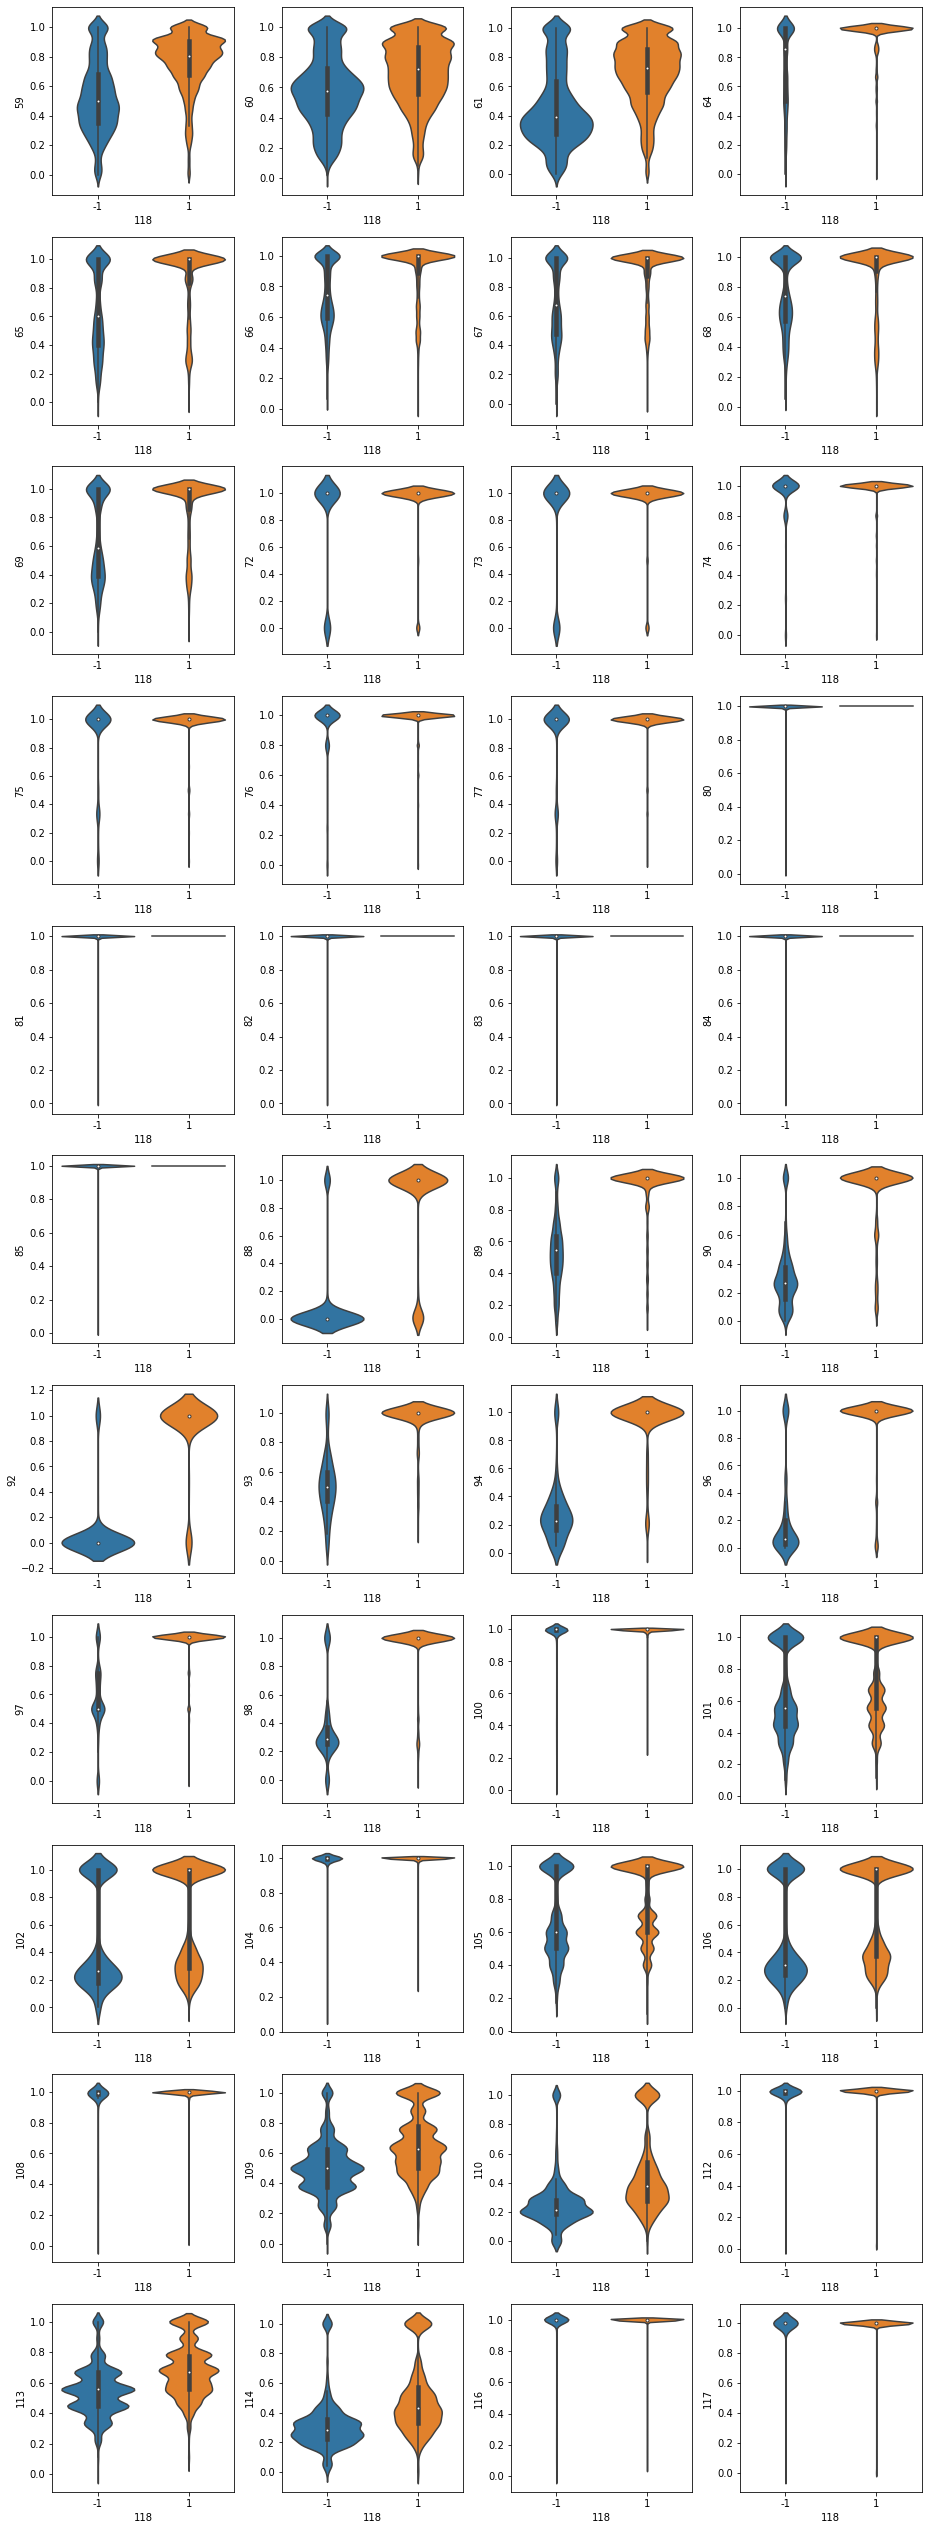

In [13]:
n_rows = 12
n_cols = 4
plt.figure(figsize=(13,38))
for i,col  in enumerate(num_df.columns[45:]):
    i +=1
    plt.subplot(n_rows,n_cols,i)
    sns.violinplot(x=target, y=num_df[col])
    plt.tight_layout()

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
         ستون های که بیشتر از ۵۰ درصد مقادیر خالی دارند را فیلتر می کنیم. 
    </font>
</div>

In [12]:
not_null_columns, at_most_columns = null_ratio(num_df,atmost_null=0.5)

In [13]:
#just for check
# num_df[at_most_columns].isna().sum()

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
         از 
        logistic Regression
        در تابع 
        univariant_importance
        به منظور
        انتخاب نهایی ستون ها استفاده کردیم
        (دیگر مدل ها نیز استفاده شد اما نتایج تغییر محسوسی نکرد).
    </font>
</div>

In [14]:
log_reg = LogisticRegression(warm_start=False)
# please read the doc string of univariant_importance function
rep = univariant_importance(log_reg, num_df,target,atmost_null=0.7)

In [15]:
#report
# please see the column 8 in violinplot and see first row of report. it show feature 8 is redundant
rep

,col,#,accuracy,"[#-1 , #+1]",majority
0,8,10940,0.572852,"[4673, 6267]",0.572852
1,9,10940,0.572852,"[4673, 6267]",0.572852
2,10,10940,0.572943,"[4673, 6267]",0.572852
3,11,10940,0.572852,"[4673, 6267]",0.572852
4,12,10940,0.572852,"[4673, 6267]",0.572852
5,13,10940,0.572852,"[4673, 6267]",0.572852
6,48,30527,0.716677,"[8793, 21734]",0.711960
7,49,30527,0.716677,"[8793, 21734]",0.711960
8,50,30527,0.720968,"[8793, 21734]",0.711960
9,51,30527,0.721001,"[8793, 21734]",0.711960


<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
         ستون های که دارای مقادیر خالی هستند اما بیش از ۵ درصد با 
        random estimator
        از حیث
        میزان درستی
        (accuracy)
        فاصله دارند را انتخاب می کنیم.
        و با نمونه گیری آنها را پر می کنیم.
    </font>
</div>

In [16]:
# please read the doc string of selected_cloumns sample_imputer function
selected_cloumns = select_columns(rep,thershold=0.05)
imputed_df = sample_imputer(data,selected_cloumns)

In [17]:
# just for check
# imputed_df[selected_cloumns].isna().sum()

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
        ستون های نهایی
        عبارت اند از
    <br>
    ۱)ستون های حاوی مقادیر خالی که اکنون پر شده اند
        (selected_cloumns)
     <br>
    ۲)ستون های عددی که از ابتدا مقادیر خالی  نداشتند
        (not_null_columns)
    <br>
    ۳)و ستون هایی گسسته ای که همگی فاقد مقادیر
        null
        بودن
    (cat_df.columns)
    </font>
</div>

In [18]:
final_cloumns = selected_cloumns+not_null_columns + list(cat_df.columns)

In [19]:
to_model = imputed_df[final_cloumns].copy()

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
         برای تبدیل دادگان 
        categorical
        به عددی 
        باتوجه به مشخص نبود جنس این دادگان
        (ordianl ,nominal,...)
        و همچنین محدود بودن تعداد 
        category
        ها در هر ویژگی
        به عنوان انتحاب اول از 
        OneHotEncoder
        استفاده شد.
        <br>
        باتوجه به اینکه کلاس ها مشخص است و اضافه یا کم نخواهد شد
        با مشکل 
        data leakage 
        برنخواهیم خورد لذا عمل 
        fit
        بر روی تمام
        نمونه های
        data_train
         انجام شد.
    </font>
</div>

In [20]:
transformer = OneHotEncoder(drop_invariant=True,cols=list(cat_df.columns))
transformer.fit(to_model)
to_model_transformed = transformer.transform(to_model)

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
        سه مدل
       RandomForestClassifier
        ، 
       LogisticRegression
       ، 
       XGBClassifier
        به عنوان مدل های نهایی انتخاب شدند.
        برای تخمین بهتر از
        cross_val_predict
        استفاده 
        شد تا تمامی دیتا ها در تخمین نهایی شرکت داشته باشد
        به این ترتیب که دادگان به ۵ دسته تقسیم شدند و هر بار یکی از دسته ها به عنوان تست و مابقی
        به عنوان دادگان آموزشی مورد استفاده قرار گرفتند
        .
        <br>
        در خروجی احتمال هر کلاس بدست آمد تا از آن
        در 
        roc_auc_score
        و
        roc_curve
        استفاده شود.
    </font>
</div>

In [23]:
rf_proba = cross_val_predict(RandomForestClassifier(),
                             to_model_transformed.values,
                             target,
                             cv=5,
                             method="predict_proba")

In [23]:
lReg_proba = cross_val_predict(LogisticRegression(solver="newton-cg"),
                               to_model_transformed.values,
                               target,
                               cv=5,
                               method="predict_proba")

In [25]:
xgb_proba = cross_val_predict(XGBClassifier(),
                             to_model_transformed.values,
                             target,
                             cv=5,
                            method="predict_proba")

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4> 
        از معیار 
        f1
        و
        auc
        برای انتخاب مدل نهایی استفاده می کنیم.
        خوشبخاته توانستیم مدل های را آموزش دهیم که در اکثر معیار های متعارف
        عملکرد بالا و هم ترازی داشته باشند.
        <br>
    نهایت چون 
    Random Forest
        و 
     XGBoot
        عملکرد مشابه ای داشتند.
        (هرچند متاسفانه فرصت tune  کردن نشد)
    Random Forset
        به عنوان مدل نهایی انتخاب شد زیرا که توانایی
        scale 
        شدن را دارد.
    </font>
</div>

 ### Random Forest

In [26]:
#please check the doc string of  proba_to_pred function
rf_pred = proba_to_pred(rf_proba)

In [27]:
print(classification_report(target.values,rf_pred))

              precision    recall  f1-score   support

          -1       0.94      0.92      0.93      8875
           1       0.97      0.98      0.97     22143

    accuracy                           0.96     31018
   macro avg       0.95      0.95      0.95     31018
weighted avg       0.96      0.96      0.96     31018



### Logistic Regression

In [28]:
#please check the doc string of  proba_to_pred function
lr_pred = proba_to_pred(lReg_proba)

In [29]:
print(classification_report(target.values,lr_pred))

              precision    recall  f1-score   support

          -1       0.90      0.89      0.90      8875
           1       0.96      0.96      0.96     22143

    accuracy                           0.94     31018
   macro avg       0.93      0.93      0.93     31018
weighted avg       0.94      0.94      0.94     31018



### XGBoost

In [30]:
#please check the doc string of  proba_to_pred function
xgb_pred = proba_to_pred(xgb_proba)

In [31]:
print(classification_report(target.values, xgb_pred))

              precision    recall  f1-score   support

          -1       0.94      0.93      0.94      8875
           1       0.97      0.98      0.97     22143

    accuracy                           0.96     31018
   macro avg       0.96      0.95      0.96     31018
weighted avg       0.96      0.96      0.96     31018



In [32]:
rf_fpr, rf_tpr, _ = roc_curve(target.values, rf_proba[:,1])
lr_fpr, lr_tpr, _ = roc_curve(target.values, lReg_proba[:,1])
xgb_fpr, xgb_tpr, _ = roc_curve(target.values, lReg_proba[:,1])

ns_probs = np.linspace(0,1,100)

In [33]:
auc_lr = round(roc_auc_score(target.values,  lReg_proba[:,1]), 4)
auc_xgb = round( roc_auc_score(target.values,  rf_proba[:,1]), 4)
auc_rf = round(roc_auc_score(target.values,  rf_proba[:,1]), 4)

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
         Random Forest و XGBoot
    هردو 
        auc 
        دقت مشابه ای تا ۴ رقم اعشار بدست اورند.
    </font>
</div>
 

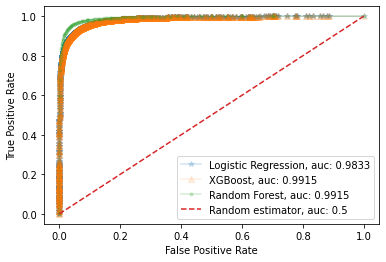

In [34]:
plt.plot(lr_fpr, lr_tpr, marker='*', label=f'Logistic Regression, auc: {auc_lr}', alpha=0.2)
plt.plot(xgb_fpr, xgb_tpr, marker='^', label=f'XGBoost, auc: {auc_xgb}', alpha=0.12)
plt.plot(rf_fpr, rf_tpr, marker='.', label=f'Random Forest, auc: {auc_rf}', alpha=0.2)
plt.plot(ns_probs, ns_probs, linestyle='--', label=f'Random estimator, auc: {0.5}')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

<div style="direction: rtl; line-height: 300%; font-family: Yas">
    <font  size=4>
    در آخر مدل نهایی بر روی کل دادگان ساخته و ذخیر شد.
    </font>
</div>

In [35]:
final_model = RandomForestClassifier().fit(to_model_transformed.values,target.values)

In [45]:
dump(final_model,"../model/final_model.joblib")
dump(selected_cloumns, "../model/selected_cloumns.joblib")
dump(transformer,"../model/transformer.joblib");